In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# First Look at the data

Data sourced from https://open-traffic.epfl.ch/index.php/downloads/#1599047632394-7ca81bff-5221 


### Data Description:
Each.csv file has the following:

- Each row represents the data of a single vehicle
- The first 4 columns include information about the trajectory
    - track_id: unique trackID,  
    - type: type of vehicle,
    - traveled_d: distance traveled in meters,
    - avg_speed: average speed of the vehicle in km/h
    
- The next columns contain information at specific time, repeated every 6 columns in this order
    - lat: latitude, at time column i+5
    - lon: logitude, at time column i+4
    - speed:  Speed is in km/h, at time column i+3
    - lon_acc: Longitudinal Acceleration in m/sec2, at time column i+2 
    - lat_acc: Lateral Acceleration in m/sec2, at time column i+1
    - time: time in seconds

### I. Reading the data

In [7]:
# data = pd.read_csv("../data/20181024_d1_0830_0900.csv", sep =';')

# data.head(5)

We cannot read the data as a simple dataframe, because the rows don't contain equal numbers of columns.

In [2]:
data_file = "../data/20181024_d1_0830_0900.csv"

sep = ';'

number_of_columns = []

with open(data_file, 'r') as file:
    lines = file.readlines()

    for line in lines:
        column_count = len(line.strip('\n').strip(' ').split(sep))

        number_of_columns.append(column_count)

print("max number of columns: ", max(number_of_columns), "\nmin number of columns: ", min(number_of_columns))

max number of columns:  122831 
min number of columns:  10


In [3]:
columns = lines[0].replace('\n','').replace(' ', '').split(sep)
print(columns)

['track_id', 'type', 'traveled_d', 'avg_speed', 'lat', 'lon', 'speed', 'lon_acc', 'lat_acc', 'time']


It makes sense (in a relational database) to split this data into two tables:

- vehicles: contains a unique row for each tack. contains unique values of first 4 columns (track_id, type, traveled_d, avg_speed)

- trajectories: contains information of tracks at various timestamps, identified by a unique combination of track_id + time.

In [4]:
col_vehicle = columns[:4]
col_trajectory = columns[:1] + columns[4:]

In [5]:
data_file = "../data/20181024_d1_0830_0900.csv"

sep = ';'

vehicle_list = []
trajectory_list = []

with open(data_file, 'r') as file:
    lines = file.readlines()
    # first line is column names
    lines = lines[1:]

    for indx, line in enumerate(lines):
        # remove trailing spaces
        line = line.strip('\n').strip(' ')

        # split the line into seperate records
        values = [value.strip(' ') for value in line.split(sep) if value]

        # first 4 values are vehicle data and the rest are trajectory data   
        vehicle_list.append(values[:4])

        traj = values[4:]
        #number of timestamps
        stamps= int(len(traj)/6)
        
        try:
            # insert trajectory data    
            assert(len(traj)%6 == 0)

            trajectory_list = trajectory_list + [values[:1] + traj[6*i: 6*(i+1)] for i in range(stamps)]

        except:
            print(f"Error in reading trajectory data at line {indx}")
            continue

In [35]:
print(len(vehicle_list))
set([len(x) for x in vehicle_list])

922


{4}

In [37]:
print(len(trajectory_list))
set([len(x) for x in trajectory_list])

1446887


{7}

In [6]:
df_vehicle = pd.DataFrame(data= vehicle_list,columns=col_vehicle)

df_vehicle.head()

,track_id,type,traveled_d,avg_speed
0,1,Car,48.85,9.770344
1,2,Motorcycle,98.09,19.839417
2,3,Motorcycle,63.80,18.228752
3,4,Motorcycle,145.72,26.229014
4,5,Motorcycle,138.01,24.841425


In [7]:
df_trajectory = pd.DataFrame(data= trajectory_list ,columns=col_trajectory)

df_trajectory.head()

,track_id,lat,lon,speed,lon_acc,lat_acc,time
0,1,37.977391,23.737688,4.9178,0.0518,-0.0299,0.000000
1,1,37.977391,23.737688,4.9207,-0.0124,-0.0354,0.040000
2,1,37.977391,23.737688,4.9160,-0.0519,-0.0413,0.080000
3,1,37.977390,23.737688,4.9057,-0.0914,-0.0478,0.120000
4,1,37.977390,23.737689,4.8871,-0.1679,-0.0550,0.160000


In [41]:
# df_vehicle.to_csv("../data/20181024_d1_0830_0900_vehicles.csv", index= False)

# df_trajectory.to_csv("../data/20181024_d1_0830_0900_trajectories.csv", index= False)

In [5]:
# df_vehicle = pd.read_csv("../data/20181024_d1_0830_0900_vehicles.csv",dtype = 'str')

# df_trajectory = pd.read_csv("../data/20181024_d1_0830_0900_trajectories.csv",dtype= 'str')

### II. Reading the data

We put the last section into a script for better organizing the code

In [7]:
import sys, os

#sys.path.append(os.path.abspath(os.path.join("../..")))
sys.path.append(os.path.abspath(os.path.join("../scripts")))

In [8]:
from read_data import Reader

In [9]:
reader = Reader()

In [10]:
data_file = "../data/20181024_d1_0830_0900.csv"

In [11]:
df_veh, df_traj = reader.data_dfs(data_file)

In [12]:
df_veh.equals(df_vehicle)

True

In [13]:
df_traj.equals(df_trajectory)

True

### Basic Exploration of Data

In [43]:
df_vehicle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   track_id    922 non-null    int64  
 1   type        922 non-null    object 
 2   traveled_d  922 non-null    float64
 3   avg_speed   922 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 28.9+ KB


In [44]:
df_trajectory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1446887 entries, 0 to 1446886
Data columns (total 7 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   track_id  1446887 non-null  int64  
 1   lat       1446887 non-null  float64
 2   lon       1446887 non-null  float64
 3   speed     1446887 non-null  float64
 4   lon_acc   1446887 non-null  float64
 5   lat_acc   1446887 non-null  float64
 6   time      1446887 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 77.3 MB


In [45]:
# basic statistics of tracks

df_vehicle.describe()

,track_id,traveled_d,avg_speed
count,922.000000,922.000000,922.000000
mean,461.500000,289.670954,21.442594
std,266.302773,156.386219,10.812071
min,1.000000,9.370000,0.096770
25%,231.250000,169.640000,13.817063
50%,461.500000,283.355000,19.847800
75%,691.750000,459.822500,28.778046
max,922.000000,502.330000,52.992695


In [46]:
# basic statistics of timed trajectory data

df_trajectory.describe()

,track_id,lat,lon,speed,lon_acc,lat_acc,time
count,1.446887e+06,1.446887e+06,1.446887e+06,1.446887e+06,1.446887e+06,1.446887e+06,1.446887e+06
mean,4.199783e+02,3.797881e+01,2.373660e+01,1.664504e+01,-4.706493e-03,4.248032e-02,4.150876e+02
std,2.536363e+02,9.283493e-04,8.656107e-04,1.554383e+01,8.257478e-01,4.155610e-01,2.392626e+02
min,1.000000e+00,3.797685e+01,2.373441e+01,0.000000e+00,-3.243770e+01,-8.259700e+00,0.000000e+00
25%,2.000000e+02,3.797815e+01,2.373590e+01,0.000000e+00,-2.267000e-01,-3.090000e-02,2.008200e+02
50%,4.070000e+02,3.797879e+01,2.373656e+01,1.584690e+01,0.000000e+00,0.000000e+00,4.355200e+02
75%,6.250000e+02,3.797951e+01,2.373734e+01,2.934340e+01,2.204000e-01,6.500000e-02,6.190000e+02
max,9.220000e+02,3.798125e+01,2.373849e+01,1.014100e+02,4.465970e+01,2.293310e+01,8.188000e+02


In [47]:
x = df_vehicle['track_id'].unique()
y = df_trajectory['track_id'].unique()
all(x==y)

True

In [48]:
df_1 = df_trajectory[df_trajectory['track_id'] == 1]

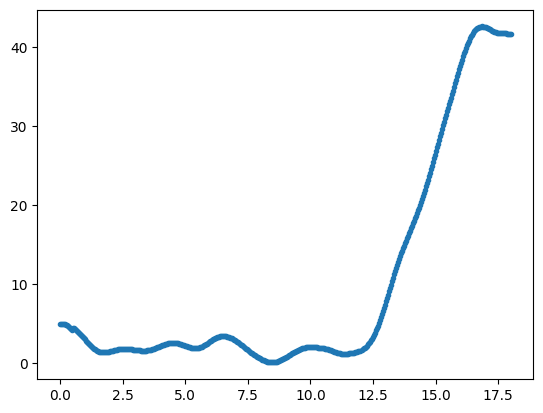

In [57]:
plt.scatter(x=df_1['time'], y=df_1['speed'], marker='.')

plt.show()

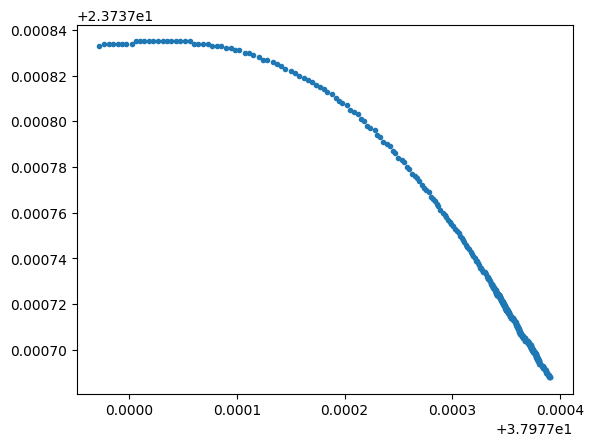

In [59]:
plt.scatter(x=df_1['lat'], y=df_1['lon'], marker='.')

plt.show()